In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import msise00
import matplotlib

## Run NRLMSISE-00 model for every hour of a year

Calculated for CLASS observing site on Cerro Toco.

In [2]:
alts = np.arange(5, 101)
temp_profiles = []
pres_profiles = []
time = datetime.datetime(2017, 1, 1)
for i in range(365 * 24):
    result = msise00.base.rungtd1d(time=time, altkm=alts, glat=-22.959748, glon=-67.787260)
    temp = result['Tn'].values.flatten() # K
    # R from CIPM-2007, https://doi.org/10.1088/0026-1394/45/2/004
    pres = result['Total'].values.flatten() * 287.0 * temp # Pa
    temp_profiles.append(temp)
    pres_profiles.append(pres)
    time += datetime.timedelta(hours=1)
temp_profiles = np.array(temp_profiles)
pres_profiles = np.array(pres_profiles)

## Compare to International Standard Atmosphere

In [3]:
def isa(altitude):
    '''
    Calculates temperature and pressure using International Standard Atmosphere.

    Parameters
    ----------
    altitude : float
        Geopotential altitude (m)

    Returns
    -------
    float
        Temperature of atmosphere layer (K)
    float
        Pressure of atmosphere layer (mbar)
    '''
    g = 9.81 # m/s^2
    R = 287  # J/kg/K
    heights = [-610, 11e3, 20e3, 32e3, 47e3, 51e3, 71e3, 84852] # m
    lapse_rates = [6.5, 0.0, -1.0, -2.8, 0.0, 2.8, 2.0] # K / km
    pres = 1089
    temp = 292.15  
    for i in range(1, len(heights)):
        h = heights[i] if altitude > heights[i] else altitude
        temp_diff = lapse_rates[i - 1] / 1e3 * (heights[i - 1] - h)
        if np.abs(lapse_rates[i - 1]) > 0:
            pres *= ((temp + temp_diff) / temp)**(g / (lapse_rates[i-1] / 1000) / R)
        else:
            pres *= np.exp(-g / R / temp * (h - heights[i - 1]))
        temp += temp_diff
        if altitude <= heights[i]:
            return temp, pres

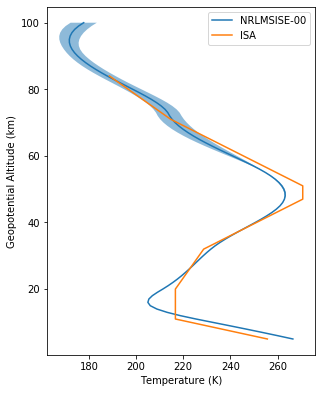

In [4]:
plt.figure(figsize=(4.8, 6.4))
plt.plot(np.mean(temp_profiles, axis=0), alts, label='NRLMSISE-00')
plt.fill_betweenx(alts, np.mean(temp_profiles, axis=0)+np.std(temp_profiles, axis=0)/2, np.mean(temp_profiles, axis=0)-np.std(temp_profiles, axis=0)/2, alpha=0.5)
plt.plot(np.array([isa(alt * 1000)[0] for alt in alts[:-16]]), alts[:-16], label='ISA')
plt.xlabel('Temperature (K)')
plt.ylabel('Geopotential Altitude (km)')
plt.legend()

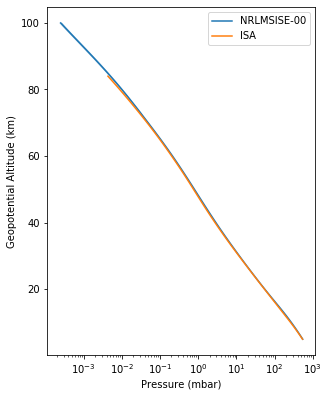

In [5]:
plt.figure(figsize=(4.8, 6.4))
plt.semilogx(np.mean(pres_profiles, axis=0)/100, alts, label='NRLMSISE-00')
plt.fill_betweenx(alts, np.mean(pres_profiles, axis=0)/100+np.std(pres_profiles, axis=0)/2/100, np.mean(pres_profiles, axis=0)/100-np.std(pres_profiles, axis=0)/2/100, alpha=0.5)
plt.semilogx(np.array([isa(alt * 1000)[1] for alt in alts[:-16]]), alts[:-16], label='ISA')
plt.xlabel('Pressure (mbar)')
plt.ylabel('Geopotential Altitude (km)')
plt.legend()

## Save atmosphere profile

In [6]:
profile = np.vstack((alts * 1e3, np.mean(temp_profiles, axis=0), np.mean(pres_profiles, axis=0) / 100, np.std(temp_profiles, axis=0), np.std(pres_profiles, axis=0) / 100)).T
np.savetxt('../input-data/cerro_toco_atm_profile.txt', profile, header='Year-round average from NRLMSISE-00 for Cerro Toco\nAltitude (m), Temperature (K), Pressure (mbar), Temperature stddev (K), Pressure stddev (mbar)', fmt='%.8e')